In [24]:
import dolfin as dolf
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

from helmholtz_pkg.passive_flame import PassiveFlame
from helmholtz_pkg.flame_transfer_function import n_tau
from helmholtz_pkg.active_flame import ActiveFlame
from helmholtz_pkg.eigensolvers import fixed_point_iteration_pep
from helmholtz_pkg.eigenvectors import normalize_eigenvector, normalize_adjoint
from helmholtz_pkg.petsc4py_utils import vector_matrix_vector
import params

In [25]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)

    return mesh, boundaries, subdomains

In [26]:
degree = 1

mesh, boundaries, subdomains = mshr(400)

boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                        2: {'Robin': params.Y_out}}  # outlet

foo = PassiveFlame(mesh, boundaries, boundary_conditions,
                    c=params.c_,
                    degree=degree)
foo.assemble_A()
foo.assemble_B()
foo.assemble_C()

In [27]:
ftf = n_tau(params.n, params.tau)

D_base = ActiveFlame(mesh, subdomains,
                params.x_f, params.x_r, params.rho_in, 1., 1., ftf,
                degree=degree)

D_base.assemble_submatrices(problem_type='direct')
D_base.assemble_submatrices(problem_type='adjoint')

E_dir = fixed_point_iteration_pep(foo, D_base, pi, nev=2, i=0, problem_type='direct',tol=1e-15, maxiter=100)
E_adj = fixed_point_iteration_pep(foo, D_base, pi, nev=2, i=1, problem_type='adjoint',tol=1e-15, maxiter=100)

omega_base, p_base = normalize_eigenvector(mesh, E_dir, i=0, degree=degree, which='right')
omega_adj, p_adj = normalize_eigenvector(mesh, E_adj, i=1, degree=degree, which='left')

# BASE STATE SENSITIVITY ------------------------------------------------------------------------------------------

p_dir_vec = p_base.vector().vec()
p_adj_vec = p_adj.vector().vec()

# dLds = -D.get_derivative(omega_dir) + foo.B + foo.assemble_zC(2 * omega_dir)

# denominator = vector_matrix_vector(p_adj_vec , dLds , p_dir_vec )
#print(denominator)
# sensitivity for n
D_base.assemble_matrix(omega_base)
dNdn = D_base.matrix / params.n


iter =  1,  omega = +3.427581991086694  +0.014369810162020j,  |domega| = 1.29e-02
iter =  2,  omega = +3.425410406417154  +0.001990366417685j,  |domega| = 1.26e-02
iter =  3,  omega = +3.425410708138722  +0.001991532305515j,  |domega| = 1.20e-06
iter =  4,  omega = +3.425410708119894  +0.001991532251623j,  |domega| = 5.71e-11
iter =  5,  omega = +3.425410708119906  +0.001991532251622j,  |domega| = 1.24e-14
iter =  6,  omega = +3.425410708119855  +0.001991532251627j,  |domega| = 5.09e-14
iter =  7,  omega = +3.425410708119931  +0.001991532251624j,  |domega| = 7.56e-14
iter =  8,  omega = +3.425410708119920  +0.001991532251622j,  |domega| = 1.13e-14
iter =  9,  omega = +3.425410708119923  +0.001991532251622j,  |domega| = 3.19e-15
iter = 10,  omega = +3.425410708119923  +0.001991532251622j,  |domega| = 4.52e-16
iter =  1,  omega = +3.427581991086758  -0.014369810162021j,  |domega| = 1.29e-02
iter =  2,  omega = +3.425410406417217  -0.001990366417687j,  |domega| = 1.26e-02
iter =  3,  omeg

### Sensitivity of parameter n

In [28]:
norm_adj = normalize_adjoint(omega_base, p_base, p_adj, foo, D_base)
dsdn = vector_matrix_vector(norm_adj.vector().vec(), dNdn , p_dir_vec )
dsdn

(-0.02299410492022537+0.17881656280381658j)

## Taylor Test for parameter n

In [29]:
def find_new_s(n):
    ftf = n_tau(n, params.tau)

    D = ActiveFlame(mesh, subdomains,
                    params.x_f, params.x_r, params.rho_in, 1., 1., ftf,
                    degree=degree)

    D.assemble_submatrices(problem_type='direct')


    E = fixed_point_iteration_pep(foo, D, pi, nev=2, i=0, problem_type='direct',tol=1e-15, maxiter=100)

    omega_new, p_new = normalize_eigenvector(mesh, E, i=0, degree=degree, which='right')
    
    return omega_new

## BASED ON ARFM PAPER

In [30]:
points = 20 # number of points
dn = 0.000010
dds = np.zeros(points, dtype=complex)
epsilons = np.zeros(points)


In [31]:
n_base = params.n

for nn in range(1,points):
    
    # Calculate Adjoint Sensitivity
    ds_AD = dsdn * nn*dn 
    
    #New n
    n = n_base + nn*dn  
    
    
    print("new n; ",n, "new epsilon; ",nn*dn )
    
    # Calculate new eigenvalue with new n
    new_omega = find_new_s(n)
    # Calculate FD Sensitivity
    ds_FD = (new_omega - omega_base)
    
    print("\nn_base = ", params.n, " n1 = ", n)
    print("\n", ds_AD, " ?= ",new_omega - omega_base,"\n")
    
    

    dds[nn] = ds_AD - ds_FD 
    print("Difference: ", ds_AD - ds_FD)
    epsilons[nn] = nn*dn 
    print("----------------------------------------------------------------------")
    

new n;  0.16139844387770283 new epsilon;  1e-05
iter =  1,  omega = +3.427581871750216  +0.014370705503569j,  |domega| = 1.29e-02
iter =  2,  omega = +3.425410176446793  +0.001992154683364j,  |domega| = 1.26e-02
iter =  3,  omega = +3.425410478200090  +0.001993320470096j,  |domega| = 1.20e-06
iter =  4,  omega = +3.425410478181258  +0.001993320416210j,  |domega| = 5.71e-11
iter =  5,  omega = +3.425410478181255  +0.001993320416209j,  |domega| = 2.72e-15
iter =  6,  omega = +3.425410478181254  +0.001993320416209j,  |domega| = 8.94e-16
Normalization relation is | p p dx = 1 

n_base =  0.16138844387770282  n1 =  0.16139844387770283

 (-2.299410492022537e-07+1.788165628038166e-06j)  ?=  (-2.2993866810594454e-07+1.7881645867985803e-06j) 

Difference:  (-2.3810963091627947e-12+1.0412395856689233e-12j)
----------------------------------------------------------------------
new n;  0.1614084438777028 new epsilon;  2e-05
iter =  1,  omega = +3.427581752415761  +0.014371600845697j,  |domega| = 1

iter =  5,  omega = +3.425408408949494  +0.002009413803817j,  |domega| = 4.91e-15
iter =  6,  omega = +3.425408408949494  +0.002009413803817j,  |domega| = 6.51e-18
Normalization relation is | p p dx = 1 

n_base =  0.16138844387770282  n1 =  0.1614884438777028

 (-2.2994104920225373e-06+1.788165628038166e-05j)  ?=  (-2.2991704291541737e-06+1.788155219485015e-05j) 

Difference:  (-2.4006286836363974e-10+1.0408553151116545e-10j)
----------------------------------------------------------------------
new n;  0.16149844387770282 new epsilon;  0.00011
iter =  1,  omega = +3.427580678496479  +0.014379658950860j,  |domega| = 1.29e-02
iter =  2,  omega = +3.425407877007500  +0.002010037226181j,  |domega| = 1.26e-02
iter =  3,  omega = +3.425408179077687  +0.002011202001415j,  |domega| = 1.20e-06
iter =  4,  omega = +3.425408179058844  +0.002011201947587j,  |domega| = 5.70e-11
iter =  5,  omega = +3.425408179058842  +0.002011201947587j,  |domega| = 1.79e-15
iter =  6,  omega = +3.425408179058842

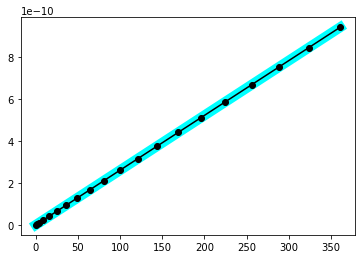

In [32]:
plt.plot([0,(points-1)**2],[0,max(abs(dds))], linewidth = 10.0, color='cyan') #Straight Line
plt.plot(np.arange(0,points)**2, abs(dds),'o-k') # Actual Line
plt.show()
